<a href="https://colab.research.google.com/github/eriksali/DNN_2023_DL/blob/main/a3_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[1,   200] loss: 1.609
[1,   400] loss: 1.605
[2,   200] loss: 1.595
[2,   400] loss: 1.568
[3,   200] loss: 1.235
[3,   400] loss: 0.861
[4,   200] loss: 0.645
[4,   400] loss: 0.580
[5,   200] loss: 0.548
[5,   400] loss: 0.526


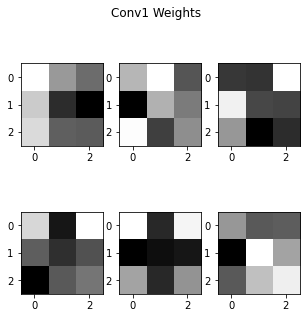

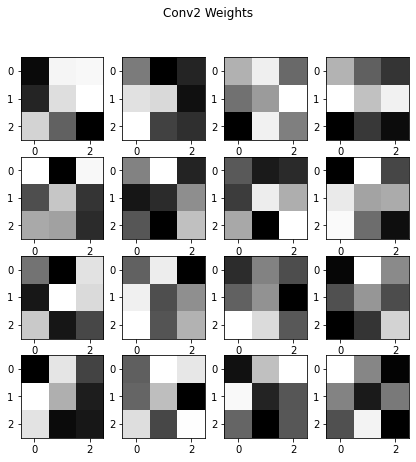

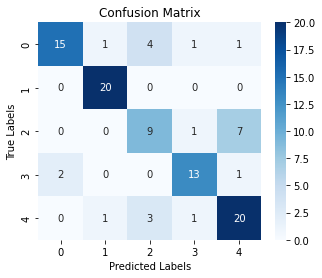

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader

# Select 5 classes: T-shirt/top, Trouser, Pullover, Dress, Coat
selected_classes = [0, 1, 2, 3, 4]

##original_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Create a custom subset that contains only the selected classes
selected_indices = []
for i in range(len(train_dataset)):
    _, label = train_dataset[i]
    if label in selected_classes:
        selected_indices.append(i)

selected_train_dataset = Subset(train_dataset, selected_indices)

batch_size = 64
selected_train_loader = DataLoader(selected_train_dataset, batch_size=batch_size, shuffle=True)

##original_testset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Create a custom subset that contains only the selected classes
selected_indices = []
for i in range(len(test_dataset)):
    _, label = test_dataset[i]
    if label in selected_classes:
        selected_indices.append(i)

selected_test_dataset = Subset(test_dataset, selected_indices)
import random
# Select a random subset of 100 images from the test dataset
test_subset_indices = random.sample(range(len(selected_test_dataset)), k=100)
test_subset = Subset(selected_test_dataset, test_subset_indices)


batch_size = 64
selected_test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

# Define function to flip images horizontally or vertically
def flip_images(images, mode='horizontal'):
    if mode == 'horizontal':
        return torch.flip(images, dims=[3])
    elif mode == 'vertical':
        return torch.flip(images, dims=[2])
    else:
        raise ValueError("Invalid mode")

# Flip test images vertically and measure accuracy
test_subset_flipped_vertical = [(flip_images(images, mode='vertical'), labels) for images, labels in test_subset]
test_loader_flipped_vertical = torch.utils.data.DataLoader(test_subset_flipped_vertical, batch_size)


import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 6, 3)  # input_channel=1, output_channel=6, kernel_size=3
        self.pool1 = nn.AvgPool2d(2, 2) # kernel_size=2, stride=2
        self.conv2 = nn.Conv2d(6, 16, 3) # input_channel=6, output_channel=16, kernel_size=3
        self.pool2 = nn.AvgPool2d(2, 2) # kernel_size=2, stride=2
        
        # Define fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # input_size=16*5*5, output_size=120
        self.fc2 = nn.Linear(120, 84)         # input_size=120, output_size=84
        self.fc3 = nn.Linear(84, 5)           # input_size=84, output_size=4

    def forward(self, x):
        # Apply convolutional layers with activation functions and pooling layers
        x = nn.functional.relu(self.conv1(x))
        x = self.pool1(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Flatten output from convolutional layers
        x = torch.flatten(x, 1)
        
        # Apply fully connected layers with activation functions
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x



net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(selected_train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

# Extract the weights of the filters in both convolutional layers
conv1_weights = net.conv1.weight.detach().clone()
conv2_weights = net.conv2.weight.detach().clone()

import matplotlib.pyplot as plt

# Define the function to extract and visualize the weights of the filters
def visualize_filters(net):
    conv1_weights = net.conv1.weight.detach().cpu().numpy()
    conv2_weights = net.conv2.weight.detach().cpu().numpy()

    fig, axs = plt.subplots(2, 3, figsize=(5,5))
    fig.suptitle('Conv1 Weights')
    for i in range(2):
        for j in range(3):
            axs[i, j].imshow(conv1_weights[i*3+j][0], cmap='gray')
            #axs[i, j].axis('off')

    fig, axs = plt.subplots(4, 4, figsize=(7,7))
    fig.suptitle('Conv2 Weights')
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(conv2_weights[i*4+j][0], cmap='gray')
            #axs[i, j].axis('off')

visualize_filters(net)

path = F"/content/cnn_model_5.pt" 
torch.save(net.state_dict(), path)

predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader_flipped_vertical:
    ##for inputs, labels in selected_test_loader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted)
        true_labels.append(labels)

predictions = torch.cat(predictions, dim=0)
true_labels = torch.cat(true_labels, dim=0)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=selected_classes)

plt.figure(figsize=(5, 4))
#sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

